
### NAPE_Py3_7 environment

In [1]:
import cv2
import imageio_ffmpeg
import imageio

import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage

In [48]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]


In [3]:
fdir = r'D:\20200410_gcamp_chrmine\vj_ofc_imageactivate_01_300_stim-013'
fname = 'vj_ofc_imageactivate_01_300_stim-013'

fname_sima = fname + '_sima_mc.h5'

In [4]:
h5_file = h5py.File(os.path.join(fdir, fname_sima), 'r')
im = np.squeeze(np.array(h5_file.get(list(h5_file)[0]).value))
print(im.dtype)
im.shape

int16


(673, 513, 513)

In [20]:
# initialize how many frames to average
nframes_avg = 3 # number of frames on one side of reference frame (1 would be 3 frame avg)
interval = nframes_avg + 1

n_samples = im.shape[0]
n_ypix = im.shape[1]
n_xpix = im.shape[2]
start_time = 0 # seconds
end_time = 22.5 # seconds

tvec = np.round(np.linspace(start_time, end_time, n_samples), decimals = 1)

fs = np.round( float(n_samples)/(end_time - start_time), decimals = 2)/interval
fs

7.4775

In [21]:
stim_locs = [ (220, 250),
              (180, 300),
              (220, 350)]

#stim_locs = [ 
#              (220, 250),
#              ]

stim_initial_delay = 10 # s
stim_pulse_dur = 0.01 # s
stim_IPI = 0.49 # s
stim_reps = 10

stim_onset = []
cumulative_time = stim_initial_delay
for irep in range(stim_reps):
    
    if irep == 0:
        stim_onset.append(stim_initial_delay)
    else:
        stim_onset.append(cumulative_time)
    
    cumulative_time += stim_pulse_dur + stim_IPI
        
stim_onset

[10, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5]

In [22]:
# convert data to appropriate type
# https://stackoverflow.com/questions/25485886/how-to-convert-a-16-bit-to-an-8-bit-image-in-opencv
if np.issubdtype(np.uint16, im[0,0,0]) | np.issubdtype(np.int16, im[0,0,0]):
    
    ratio = np.amax(im) / 255
    data = np.squeeze(im/ratio) # USER DEFINE!!!
    
elif np.issubdtype(np.float32, im[0,0,0]):
    
    data = im / np.max(im) # normalize the data to 0 - 1
    data = 255 * data # Now scale by 255

else:
    ratio = 1

im_uint8 = data.astype(np.uint8)

C:\Users\stuberadmin\Anaconda3\envs\NAPE_Py3_7\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Conversion of the second argument of issubdtype from `0` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int16 == np.dtype(0).type`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
# define if want to trim borders and create save array
trim_border = 0
trim_pix = 0

if trim_border == 1:
    ypix_include = [trim_pix,n_ypix-trim_pix]
    xpix_include = [trim_pix,n_xpix-trim_pix]
else:
    ypix_include = [0,n_ypix]
    xpix_include = [0,n_xpix]

ypix_total = len(range(ypix_include[0],ypix_include[1]))
xpix_total = len(range(xpix_include[0],xpix_include[1]))
    
im_final = np.empty([len(range(interval,n_samples-interval,interval)),ypix_total,xpix_total], dtype='uint8')
im_final.shape

(167, 513, 513)

In [53]:

# vid params
vid_fps = 10.0
contrast = 0.5
brightness = 0

fout_path = os.path.join(fdir, fname + '_movie.avi')

# text params
font = cv2.FONT_HERSHEY_SIMPLEX
text_color = (200,255,155)

# arrow params
arrow_color = (200,255,155)  
thickness = 7


In [54]:
looping_frames = range(nframes_avg,n_samples-interval,interval)
num_video_frames = len(looping_frames)
im_final = np.empty([num_video_frames, ypix_total, xpix_total], dtype='uint8')

# loop through each block of frames to average

frame_count = 0
for iframe in looping_frames:
    
    if nframes_avg == 0:
        frames = iframe
        im_avg = im_uint8[frames,ypix_include[0]:ypix_include[1],xpix_include[0]:xpix_include[1]]
    else:     
        frames = slice(iframe-nframes_avg,iframe+nframes_avg)
        im_avg = np.mean( 
            im_uint8[frames,ypix_include[0]:ypix_include[1],xpix_include[0]:xpix_include[1]], axis = 0 )

    # add time in seconds
    frame_time = np.round(frame_count/fs, decimals = 2)
    img_annote = cv2.putText(im_avg, str(frame_time) + ' sec' ,(30,50), 
                           font, 1, text_color, 2, cv2.LINE_AA)
    
    # add arrows indicating stim event
    if iframe in np.round(np.multiply(stim_onset, fs)):

        for stim_loc in stim_locs:
            arrow_start = tuple(np.subtract(stim_loc, (30, 30))) # get arrow start loc by subtracting 30 pixels for x and y
            arrow_end = stim_loc
            img_annote = cv2.arrowedLine(img_annote, arrow_start, arrow_end, 
                                                 arrow_color, thickness, tipLength = 0.3) 
    
    # change brightness/contrast
    img_annote = contrast*img_annote + brightness
    # img_annote = img_annote * (contrast/127+1) - contrast + brightness
    img_annote = np.clip(img_annote, 0, 255)
    
    im_final[frame_count,:,:] = img_annote
    
    frame_count += 1


In [55]:
# save the movie
print(fout_path)
imageio.mimwrite(fout_path, im_final , fps = 15.0)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (513, 513) to (528, 528) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


D:\20200410_gcamp_chrmine\vj_ofc_imageactivate_01_300_stim-013\vj_ofc_imageactivate_01_300_stim-013_movie.avi


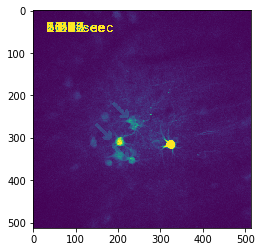

In [27]:
plt.imshow(np.mean(im_final, axis = 0))
#plt.axis([100, 400, 200, 400])
#plt.gca().invert_yaxis()
plt.clim([50, 70])

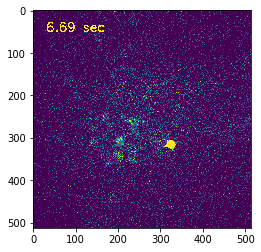

In [29]:
plt.imshow(im_final[50,:,:])
plt.clim([50, 70])